<a href="https://colab.research.google.com/github/ifty54/Projects/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Object(*Vegetables*) Localization

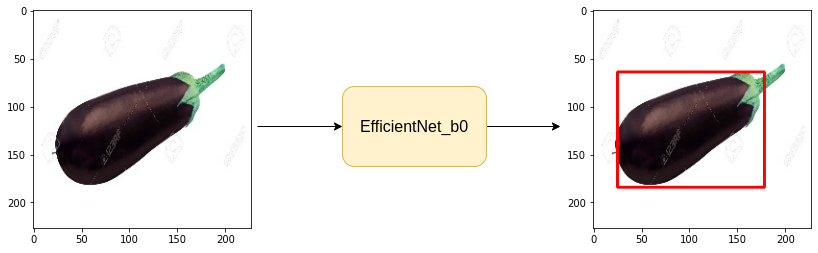

#Step 1: Install libraries/packages/modules

In [41]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cu5n8no6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cu5n8no6
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Step 2: Importing Dataset

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Step 3: Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

device = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


#Step 4: Understand the dataset

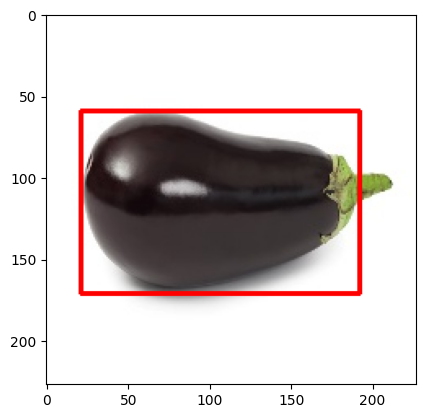

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)

plt.imshow(img)

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

#Step 5: Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

#Step 6: Create Custom Dataset

In [11]:
from torch.utils.data import Dataset
class ObjLocDataset(Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def len(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0 #h,w,c to c,h,w
    bbox = torch.Tensor(bbox)

    return img, bbox


In [12]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [13]:
print(f"Examples of Trainset: {len(list(trainset))}")
print(f"Examples of Validset: {len(list(validset))}")

Examples of Trainset: 148
Examples of Validset: 38


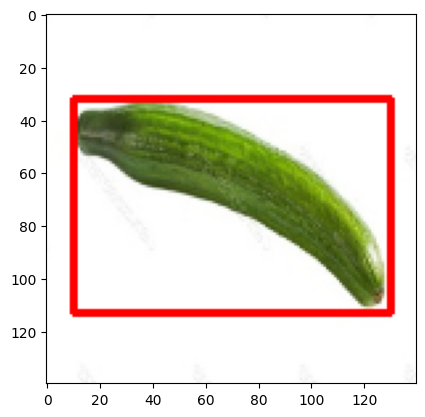

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

#Step 7: Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(list(trainset), batch_size=BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(list(validset), batch_size=BATCH_SIZE, shuffle = False)

In [16]:
print(f"Total batches in Trainloader: {len(trainloader)}")
print(f"Total batches in Validloader: {len(validloader)}")

Total batches in Trainloader: 10
Total batches in Validloader: 3


In [17]:
for images, bboxes in trainloader:
  break;

print(f"Shape of one batch images : {images.shape}")
print(f"Shape of one batch bboxes : {bboxes.shape}")

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


#Step 8: Create Model

In [18]:
from torch import nn
import timm

In [32]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [33]:
model = ObjLocModel()
model.to(device)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [34]:
random_img = torch.rand(1,3,140,140).to(device)
model(random_img).shape

torch.Size([1, 4])

#Step 9: Create Train and Eval Function

In [35]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() #Dropout is ON

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(device), gt_bboxes.to(device)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [28]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() #Dropout is ON

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(device), gt_bboxes.to(device)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss/len(dataloader)

#Step 10: Training Loop

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [37]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'my-model2.pt')
    print("Weights are saved!")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 1 | Train Loss: 5300.8719482421875 | Valid Loss: 5949.874186197917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 2 | Train Loss: 1906.2494140625 | Valid Loss: 3765.7035319010415


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 3 | Train Loss: 1178.7550842285157 | Valid Loss: 919.8678181966146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 4 | Train Loss: 816.4690612792969 | Valid Loss: 146.2294133504232


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 546.4536895751953 | Valid Loss: 151.67277018229166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 376.64964447021487 | Valid Loss: 204.76043701171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 267.8205001831055 | Valid Loss: 180.1595713297526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 196.0514778137207 | Valid Loss: 201.15509541829428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 157.55886459350586 | Valid Loss: 163.9626719156901


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 10 | Train Loss: 112.46941986083985 | Valid Loss: 141.80221811930338


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 11 | Train Loss: 76.24673690795899 | Valid Loss: 130.61695607503256


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 12 | Train Loss: 67.10606117248535 | Valid Loss: 109.09644571940105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 13 | Train Loss: 58.483055877685544 | Valid Loss: 101.67229715983073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 43.978810691833495 | Valid Loss: 125.36708577473958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 15 | Train Loss: 44.62524185180664 | Valid Loss: 80.47620137532552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 42.97173862457275 | Valid Loss: 94.92345937093098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 56.72863235473633 | Valid Loss: 93.01261138916016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 18 | Train Loss: 35.6401948928833 | Valid Loss: 79.0649528503418


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch: 19 | Train Loss: 34.89875087738037 | Valid Loss: 61.999898274739586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 32.9734206199646 | Valid Loss: 99.54679616292317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 28.661276245117186 | Valid Loss: 74.01445007324219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 30.0742600440979 | Valid Loss: 77.26335525512695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 19.744051456451416 | Valid Loss: 74.15594100952148


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 25.36686577796936 | Valid Loss: 66.15199661254883


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 19.81329755783081 | Valid Loss: 70.8353640238444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 23.303539037704468 | Valid Loss: 84.63849385579427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 21.087009239196778 | Valid Loss: 74.42406590779622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 27.522561645507814 | Valid Loss: 78.8545150756836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 36.59799709320068 | Valid Loss: 73.3911959330241


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 28.486660385131835 | Valid Loss: 98.85971577962239


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 15.569752407073974 | Valid Loss: 81.06204986572266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 26.965607261657716 | Valid Loss: 63.347390492757164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 22.459180927276613 | Valid Loss: 75.12576293945312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 28.676738691329955 | Valid Loss: 75.27569325764973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 24.607055568695067 | Valid Loss: 69.09056599934895


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 18.436420249938966 | Valid Loss: 67.86200459798177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 31.353649806976318 | Valid Loss: 77.97873814900716


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 29.884679126739503 | Valid Loss: 74.6924057006836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 23.258202886581422 | Valid Loss: 91.68627675374348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 38.1122841835022 | Valid Loss: 73.31724802652995


#Step 11: Inference

In [38]:
import utils

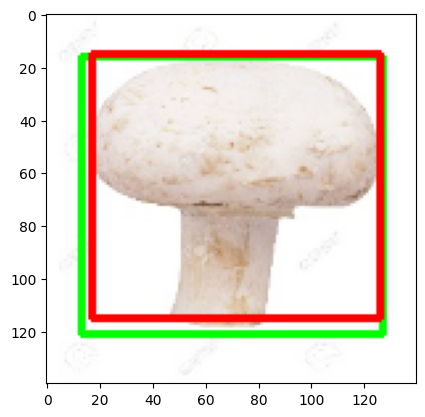

In [40]:
model.load_state_dict(torch.load('my-model2.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[1] #c,h,w
  image = image.unsqueeze(0).to(device) #b,c,h,w
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)